# Projet 7 : Implémentez un modèle de scoring

In [2]:
# Installation de MLFlow :
#!pip install mlflow

In [17]:
ls

 Le volume dans le lecteur C s'appelle OS
 Le num‚ro de s‚rie du volume est 16B0-36CC

 R‚pertoire de C:\Users\SOUKA\anaconda3\envs\projet7_IMS

28/10/2024  12:11    <DIR>          .
28/10/2024  12:11    <DIR>          ..
28/10/2024  12:08    <DIR>          .ipynb_checkpoints
17/09/2024  11:08                 0 .nonadmin
01/04/2024  11:32            22ÿ056 api-ms-win-core-console-l1-1-0.dll
01/04/2024  11:32            21ÿ960 api-ms-win-core-console-l1-2-0.dll
01/04/2024  11:32            22ÿ056 api-ms-win-core-datetime-l1-1-0.dll
01/04/2024  11:32            21ÿ960 api-ms-win-core-debug-l1-1-0.dll
01/04/2024  11:32            22ÿ056 api-ms-win-core-errorhandling-l1-1-0.dll
01/04/2024  11:32            22ÿ056 api-ms-win-core-fibers-l1-1-0.dll
01/04/2024  11:32            21ÿ960 api-ms-win-core-fibers-l1-1-1.dll
01/04/2024  11:32            26ÿ056 api-ms-win-core-file-l1-1-0.dll
01/04/2024  11:32            22ÿ072 api-ms-win-core-file-l1-2-0.dll
01/04/2024  11:32            22ÿ056 api-m

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, fbeta_score, make_scorer
)
import time
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV
import shap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint
from scipy.stats import uniform
import joblib

In [2]:
data = pd.read_csv('df_top_features.csv')

In [5]:
data

,Unnamed: 0,EXT_SOURCES_MAX,EXT_SOURCES_MIN,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_2,APP_SCORE2_TO_BIRTH_RATIO,EXT_SOURCE_3,DAYS_BIRTH,APP_SCORE3_TO_BIRTH_RATIO,DAYS_EMPLOYED,...,POS_LOAN_COMPLETED_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_HOUR_APPR_PROCESS_START_MAX,POS_CNT_INSTALMENT_MIN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_AVG,CLOSED_DAYS_CREDIT_VAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,TARGET,SK_ID_CURR
0,0,0.26300,0.08300,0.13150,0.26300,-0.010155,0.13940,-9461,-0.005383,-637.0,...,0.0000,245781.0,9.0,24.0,0.0000,0.9720,123956.70,1681.029,1,100002
1,1,0.62200,0.31130,0.62200,0.62200,-0.013560,NaN,-16765,NaN,-1188.0,...,0.2500,0.0,17.0,6.0,0.0000,0.9850,820590.30,0.000,0,100003
2,2,0.72950,0.55600,0.27800,0.55600,-0.010660,0.72950,-19046,-0.013990,-225.0,...,0.2500,0.0,5.0,3.0,0.0000,NaN,421362.00,0.000,0,100004
3,3,0.65040,0.65040,0.32520,0.65040,-0.012500,NaN,-19005,NaN,-3040.0,...,0.4583,NaN,15.0,1.0,0.0000,NaN,NaN,NaN,0,100006
4,4,0.32280,0.32280,0.16140,0.32280,-0.005913,NaN,-19932,NaN,-3038.0,...,0.2094,0.0,15.0,10.0,0.9546,NaN,NaN,0.000,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,0.68160,0.14560,0.68160,0.68160,-0.026690,NaN,-9327,NaN,-236.0,...,0.1111,NaN,17.0,7.0,0.0000,0.9880,NaN,NaN,0,456251
307502,307502,0.11597,0.11597,0.05798,0.11597,-0.002039,NaN,-20775,NaN,NaN,...,0.1428,NaN,10.0,6.0,0.5000,0.9727,NaN,NaN,0,456252
307503,307503,0.74400,0.21890,0.17860,0.53560,-0.013080,0.21890,-14966,-0.005340,-7920.0,...,0.4167,1624797.0,12.0,4.0,0.6430,0.9814,0.00,NaN,0,456253
307504,307504,0.66100,0.51400,0.25700,0.51400,-0.015700,0.66100,-11961,-0.020190,-4784.0,...,0.0000,0.0,18.0,14.0,0.0000,0.9770,NaN,NaN,1,456254


In [7]:
# Supprimer la colonne 'Unnamed: 0'
data = data.drop(columns=['Unnamed: 0'])
data

,EXT_SOURCES_MAX,EXT_SOURCES_MIN,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_2,APP_SCORE2_TO_BIRTH_RATIO,EXT_SOURCE_3,DAYS_BIRTH,APP_SCORE3_TO_BIRTH_RATIO,DAYS_EMPLOYED,PREV_DAYS_DECISION_MEAN,...,POS_LOAN_COMPLETED_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_HOUR_APPR_PROCESS_START_MAX,POS_CNT_INSTALMENT_MIN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_AVG,CLOSED_DAYS_CREDIT_VAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,TARGET,SK_ID_CURR
0,0.26300,0.08300,0.13150,0.26300,-0.010155,0.13940,-9461,-0.005383,-637.0,-606.0,...,0.0000,245781.0,9.0,24.0,0.0000,0.9720,123956.70,1681.029,1,100002
1,0.62200,0.31130,0.62200,0.62200,-0.013560,NaN,-16765,NaN,-1188.0,-1305.0,...,0.2500,0.0,17.0,6.0,0.0000,0.9850,820590.30,0.000,0,100003
2,0.72950,0.55600,0.27800,0.55600,-0.010660,0.72950,-19046,-0.013990,-225.0,-815.0,...,0.2500,0.0,5.0,3.0,0.0000,NaN,421362.00,0.000,0,100004
3,0.65040,0.65040,0.32520,0.65040,-0.012500,NaN,-19005,NaN,-3040.0,-272.5,...,0.4583,NaN,15.0,1.0,0.0000,NaN,NaN,NaN,0,100006
4,0.32280,0.32280,0.16140,0.32280,-0.005913,NaN,-19932,NaN,-3038.0,-1223.0,...,0.2094,0.0,15.0,10.0,0.9546,NaN,NaN,0.000,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,0.68160,0.14560,0.68160,0.68160,-0.026690,NaN,-9327,NaN,-236.0,-273.0,...,0.1111,NaN,17.0,7.0,0.0000,0.9880,NaN,NaN,0,456251
307502,0.11597,0.11597,0.05798,0.11597,-0.002039,NaN,-20775,NaN,NaN,-2496.0,...,0.1428,NaN,10.0,6.0,0.5000,0.9727,NaN,NaN,0,456252
307503,0.74400,0.21890,0.17860,0.53560,-0.013080,0.21890,-14966,-0.005340,-7920.0,-2380.0,...,0.4167,1624797.0,12.0,4.0,0.6430,0.9814,0.00,NaN,0,456253
307504,0.66100,0.51400,0.25700,0.51400,-0.015700,0.66100,-11961,-0.020190,-4784.0,-299.5,...,0.0000,0.0,18.0,14.0,0.0000,0.9770,NaN,NaN,1,456254


In [13]:
# Définir X et y (ajustez les noms de colonnes selon votre DataFrame)
X = data.drop(columns=['TARGET'])  # Remplacez par le nom de votre colonne cible
y = data['TARGET']  # Remplacez par le nom de votre colonne cible


In [9]:

# Vérifier les valeurs manquantes
print("Valeurs manquantes dans data :")
missing_values = data.isnull().sum()
print(missing_values)

Valeurs manquantes dans data :
EXT_SOURCES_MAX                         172
EXT_SOURCES_MIN                         172
APP_SCORE2_TO_REGION_RATING_RATIO       660
EXT_SOURCE_2                            660
APP_SCORE2_TO_BIRTH_RATIO               660
                                      ...  
YEARS_BEGINEXPLUATATION_AVG          150006
CLOSED_DAYS_CREDIT_VAR               130850
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN     123624
TARGET                                    0
SK_ID_CURR                                0
Length: 102, dtype: int64


In [15]:
# Calculer les pourcentages de valeurs manquantes
missing_percentage = (missing_values / len(X)) * 100

# Afficher les pourcentages de valeurs manquantes
print("\nPourcentage des valeurs manquantes dans X :")
print(missing_percentage)


Pourcentage des valeurs manquantes dans X :
EXT_SOURCES_MAX                       0.055934
EXT_SOURCES_MIN                       0.055934
APP_SCORE2_TO_REGION_RATING_RATIO     0.214630
EXT_SOURCE_2                          0.214630
APP_SCORE2_TO_BIRTH_RATIO             0.214630
                                       ...    
YEARS_BEGINEXPLUATATION_AVG          48.781487
CLOSED_DAYS_CREDIT_VAR               42.552015
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN     40.202142
TARGET                                0.000000
SK_ID_CURR                            0.000000
Length: 102, dtype: float64


In [339]:
# Définir le répertoire pour le tracking
mlflow.set_tracking_uri("file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/mlruns")  # Remplacez par votre chemin

In [341]:
# Créer une nouvelle expérience
experiment_name = "Mon_Experiment"  # Choisissez un nom pour votre expérience
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/142011389048118064', creation_time=1728565912066, experiment_id='142011389048118064', last_update_time=1728565912066, lifecycle_stage='active', name='Mon_Experiment', tags={}>

In [343]:
# Définir X et y (ajustez les noms de colonnes selon votre DataFrame)
X = data.drop(columns=['TARGET'])  # Remplacez par le nom de votre colonne cible
y = data['TARGET']  # Remplacez par le nom de votre colonne cible


In [345]:
# Traitement des valeurs manquantes et infinies
# Remplacer les valeurs infinies par NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [347]:
# Imputer les valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [348]:
# Conversion en DataFrame pour conserver les colonnes
X = pd.DataFrame(X_imputed, columns=X.columns)

In [349]:
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [350]:
# Division des données en ensembles d'entraînement, de validation et de test
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [354]:
# Définition des métriques personnalisées
def custom_metric(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    FP = np.sum((y == 0) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    
    PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    FMI = np.sqrt(PPV * TPR)
    return FMI

def custom_metric_f2(y, y_pred):
    return fbeta_score(y, y_pred, beta=2)

custom_scorer = make_scorer(custom_metric, greater_is_better=True)
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True)

In [355]:
# Évaluation des modèles
def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(f"Confusion Matrix:\n{conf_mat}")
    print(f'Accuracy score    : {accuracy_score(yval, yval_pred):.3}')
    print(f'Precision score   : {precision_score(yval, yval_pred):.3}')
    print(f'Recall score      : {recall_score(yval, yval_pred):.3}')
    print(f'F1 score          : {f1_score(yval, yval_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, yval_pred, beta=2):.3}')
    
    print(f'ROCAUC score      : {roc_auc_score(yval, yval_pred):.3}')
    print(f'Custom metric FMI : {custom_metric(yval, yval_pred):.3}')
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [357]:
# Entraînement et évaluation des modèles

def logistic_regression(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="Logistic Regression"):
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "Logistic Regression")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("Logistic Regression Results:")
        model_eval(model, X_val, y_val)

def random_forest(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="Random Forest"):
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "Random Forest")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("Random Forest Results:")
        model_eval(model, X_val, y_val)

def lightgbm_model(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="LightGBM"):
        model = lgb.LGBMClassifier()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "LightGBM")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("LightGBM Results:")
        model_eval(model, X_val, y_val)

In [361]:
# Comparaison avec un modèle de base (DummyClassifier)
def dummy_classifier(X_train, X_val, y_train, y_val):
    dummyCls = DummyClassifier(strategy='stratified')
    dummyCls.fit(X_train, y_train)
    
    print("Dummy Classifier Results:")
    model_eval(dummyCls, X_val, y_val)

2024/10/18 12:52:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression Results:
Confusion Matrix:
[[56431    87]
 [ 4892    92]]
Accuracy score    : 0.919
Precision score   : 0.514
Recall score      : 0.0185
F1 score          : 0.0356
F2 score          : 0.0229
ROCAUC score      : 0.508
Custom metric FMI : 0.0974



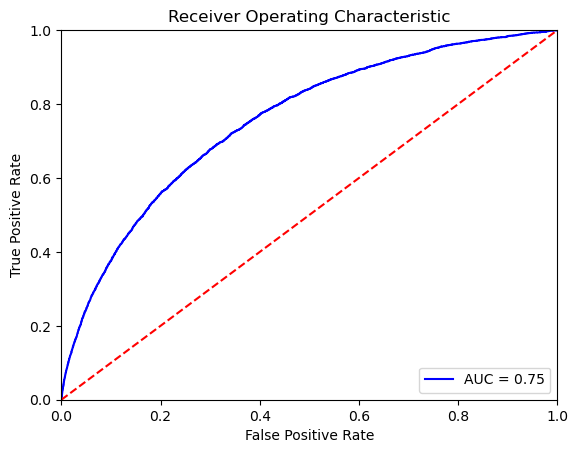

2024/10/18 12:59:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Results:
Confusion Matrix:
[[56488    30]
 [ 4932    52]]
Accuracy score    : 0.919
Precision score   : 0.634
Recall score      : 0.0104
F1 score          : 0.0205
F2 score          : 0.013
ROCAUC score      : 0.505
Custom metric FMI : 0.0813



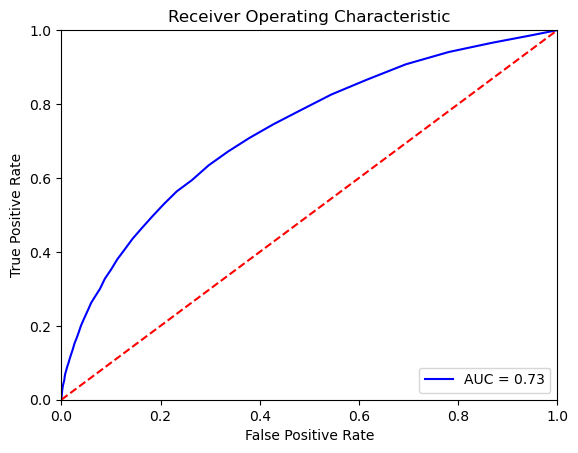

[LightGBM] [Info] Number of positive: 19840, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23894
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080649 -> initscore=-2.433560
[LightGBM] [Info] Start training from score -2.433560


2024/10/18 13:00:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM Results:
Confusion Matrix:
[[56361   157]
 [ 4812   172]]
Accuracy score    : 0.919
Precision score   : 0.523
Recall score      : 0.0345
F1 score          : 0.0647
F2 score          : 0.0424
ROCAUC score      : 0.516
Custom metric FMI : 0.134



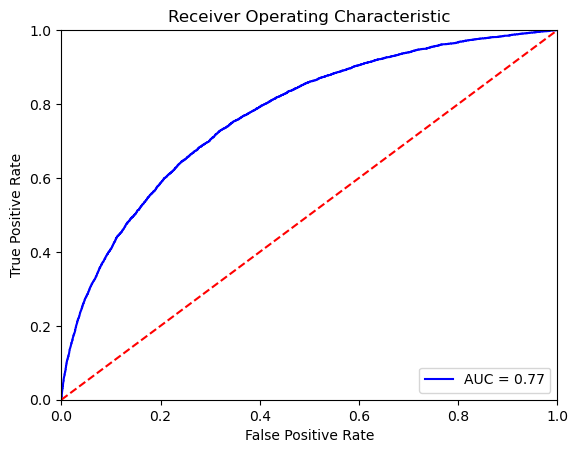

Dummy Classifier Results:
Confusion Matrix:
[[52035  4483]
 [ 4547   437]]
Accuracy score    : 0.853
Precision score   : 0.0888
Recall score      : 0.0877
F1 score          : 0.0882
F2 score          : 0.0879
ROCAUC score      : 0.504
Custom metric FMI : 0.0882



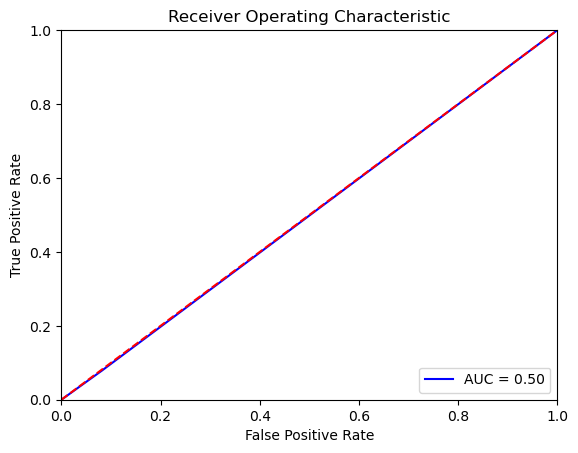

In [363]:
# Exécution des modèles
logistic_regression(X_train, X_val, y_train, y_val)
random_forest(X_train, X_val, y_train, y_val)
lightgbm_model(X_train, X_val, y_train, y_val)
dummy_classifier(X_train, X_val, y_train, y_val)


** Interprétation **
**********

  Analysons les résultats des différents modèles de classification (Régression Logistique, Forêt Aléatoire, LightGBM et Classificateur Dummy) afin d'en tirer des conclusions.

1. Précision et Performance Générale
   
Précision: Tous les modèles affichent une précision d'environ 0.919, ce qui signifie qu'ils sont corrects dans environ 92% des cas. Cependant, la précision seule peut être trompeuse, surtout dans des ensembles de données déséquilibrés.

2. Matrice de Confusion
   
La matrice de confusion indique que tous les modèles ont un nombre élevé de faux négatifs (classer incorrectement des instances positives), ce qui peut être préoccupant selon le contexte de l'application. Par exemple:
Pour la Régression Logistique: 4892 vrais positifs (VP) sont mal classés comme négatifs.
Pour le Random Forest: 4932 VP sont mal classés.
Pour LightGBM: 4812 VP sont mal classés.

3. Scores de Performance
   
Precision:

La régression logistique a la meilleure précision (0.514), ce qui signifie qu'une proportion relativement élevée des instances classées comme positives sont effectivement positives.
La précision de la forêt aléatoire est meilleure (0.634), mais cela ne se traduit pas en un bon rappel.

Recall:

Tous les modèles affichent un rappel très faible (inférieur à 0.035), ce qui indique qu'ils capturent très peu de véritables positifs par rapport au total des instances positives. Cela signifie qu'il y a un grand nombre de faux négatifs.

F1 Score:

Le F1 score est faible pour tous les modèles, en particulier pour le Random Forest (0.0205). Cela indique un déséquilibre entre la précision et le rappel. Un score faible suggère que le modèle a des difficultés à prédire les positives.

F2 Score:

Les scores F2 sont également très faibles, ce qui indique que le modèle a du mal à détecter des positives, même lorsque la précision est relativement acceptable.

ROCAUC Score:

Tous les modèles ont un score ROCAUC d'environ 0.5, ce qui indique qu'ils ne sont pas meilleurs qu'un modèle aléatoire dans la classification des classes positives et négatives.

4. Dummy Classifier
   
Le classificateur Dummy a un score d'accuracy de 0.852, ce qui est relativement bas comparé aux autres modèles, mais ses scores de précision et de rappel sont très faibles. Cela signifie qu'il est probablement en train de prédire principalement la classe majoritaire sans saisir de véritables patterns dans les données.

Conclusion Générale

Problème de déséquilibre: Les faibles scores de rappel et F1 suggèrent que les modèles peinent à prédire la classe positive, probablement en raison d'un déséquilibre entre les classes positives et négatives.


In [365]:
# Équilibrage des classes avec SMOTE

# Fonction pour équilibrer les classes
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [366]:
# Définition de la fonction de coût métier

# Fonction de coût métier
def business_cost_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    return 10 * FN + FP  # Coût métier

# Création du score de coût métier
business_cost_scorer = make_scorer(business_cost_score, greater_is_better=False)

In [367]:
# Exécution des modèles avec suivi des résultats

# Exécuter les modèles avec suivi MLflow
def run_models(X_train, X_val, y_train, y_val):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "LightGBM": lgb.LGBMClassifier(),
        "Dummy Classifier": DummyClassifier(strategy='most_frequent')
    }
    
    for model_name, model in models.items():
        with mlflow.start_run():
            # Balancer les classes
            X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)
            
            # Entraîner le modèle
            model.fit(X_train_balanced, y_train_balanced)
            
            # Prédictions
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            # Calcul des scores
            auc = roc_auc_score(y_val, y_pred_proba)
            cost_score = business_cost_score(y_val, y_pred)
            
            # Logging des résultats dans MLflow
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("AUC", auc)
            mlflow.log_metric("Business Cost", cost_score)
            mlflow.sklearn.log_model(model, "model")
            
            print(f"{model_name} - AUC: {auc:.4f}, Business Cost: {cost_score:.4f}")

# Appel de la fonction avec vos données
run_models(X_train, X_val, y_train, y_val)

2024/10/18 13:00:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - AUC: 0.7513, Business Cost: 33309.0000


2024/10/18 13:16:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - AUC: 0.7262, Business Cost: 44955.0000
[LightGBM] [Info] Number of positive: 226164, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25735
[LightGBM] [Info] Number of data points in the train set: 452328, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2024/10/18 13:16:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM - AUC: 0.7395, Business Cost: 48403.0000


2024/10/18 13:17:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dummy Classifier - AUC: 0.5000, Business Cost: 49840.0000


** Interprétation **
************

  Voici ce que nous pouvons déduire des résultats pour chacun des modèles, en se concentrant sur l'AUC (Area Under the Curve) et le coût métier :

1. Logistic Regression
   
- AUC: 0.7513
- Business Cost: 33,309
  
Interprétation:

AUC de 0.7513 est le plus élevé parmi les modèles testés, indiquant que le modèle de régression logistique a la meilleure capacité de discrimination entre les classes positives et négatives.

Le Business Cost de 33,309 est le plus bas, ce qui signifie que le modèle minimise mieux les faux négatifs et les faux positifs, en tenant compte du coût associé à chacun.

Ce modèle semble être le plus performant en termes de compromis entre la performance et le coût métier.

2. Random Forest
   
- AUC: 0.7282
- Business Cost: 45,168
  
Interprétation:

L'AUC est légèrement plus faible que celui de la régression logistique (0.7282), indiquant une capacité de classification un peu moins bonne.
Le Business Cost est plus élevé (45,168), ce qui montre que le modèle de forêt aléatoire produit plus d'erreurs de classification (faux négatifs et faux positifs) par rapport à la régression logistique.
En somme, ce modèle est moins efficace que la régression logistique à la fois en termes de score AUC et de coût métier.

3. LightGBM
   
- AUC: 0.7395
- Business Cost: 48,403
  
Interprétation:

L'AUC est intermédiaire (0.7395), mais reste inférieur à celui de la régression logistique.
Le Business Cost de 48,403 est assez élevé, ce qui signifie que le modèle fait plus d'erreurs qui sont coûteuses en termes de coût métier.
LightGBM semble donc moins performant que la régression logistique, même s'il s'approche en termes d'AUC. Cependant, le coût associé à ce modèle est plus important.

4. Dummy Classifier
   
- AUC: 0.5000
- Business Cost: 49,840
  
Interprétation:

L'AUC de 0.5000 correspond à une performance aléatoire, comme prévu pour un modèle "dummy", qui sert de base de référence.

Le Business Cost est très élevé, ce qui montre que le modèle produit beaucoup d'erreurs de classification.

Ce modèle ne fait aucune distinction entre les classes et démontre clairement une mauvaise performance en comparaison avec les autres modèles.

Conclusion générale :

Le modèle de régression logistique est clairement le plus performant parmi les modèles testés. Il présente à la fois le meilleur AUC (0.7513), et il minimise le coût métier (33,309).

Le modèle Random Forest et LightGBM montrent des performances légèrement inférieures à la régression logistique, tant en termes de score AUC que de coût métier.

Le Dummy Classifier montre la plus mauvaise performance avec un AUC de 0.5000 et le coût le plus élevé, confirmant son rôle de base de référence aléatoire.

Recommandation :

Sur la base de ces résultats, la régression logistique devrait être considérée comme la meilleure option pour ce problème de classification, car elle combine à la fois une bonne performance prédictive et un coût métier plus faible.

In [370]:
import pandas as pd
import time
import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE


In [371]:
# Définition des Scorers personnalisés
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
f1_scorer = make_scorer(f1_score)

In [372]:
# Dictionnaire pour stocker les temps de traitement
time_results = {}

# Préparer un échantillon de 20% des données
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=0.20, random_state=42)

# Fonction modifiée pour utiliser GridSearchCV avec le calcul du coût métier
def run_model(grid_search, model_name):
    with mlflow.start_run():
        # Mesurer le temps d'entraînement
        start_fit = time.time()
        grid_search.fit(X_sampled, y_sampled)  # Entraînement sur l'échantillon
        end_fit = time.time()

        fit_time = end_fit - start_fit
        time_results[f'{model_name} - Fit Time'] = fit_time

        # Mesurer le temps de prédiction
        start_predict = time.time()
        y_pred = grid_search.predict(X_val)
        end_predict = time.time()

        predict_time = end_predict - start_predict
        time_results[f'{model_name} - Predict Time'] = predict_time

        # Calcul du coût métier
        business_cost = business_cost_score(y_val, y_pred)

        # Log hyperparameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("AUC", grid_search.best_score_)
        mlflow.log_metric("F1 Score", f1_score(y_val, y_pred))
        mlflow.log_metric("Business Cost", business_cost)
        mlflow.log_metric("Fit_Time_s", fit_time)
        mlflow.log_metric("Predict_Time_s", predict_time)

        # Save model
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)

    return business_cost  # Retourner le score de coût métier

In [373]:
# Définir le modèle de régression logistique
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Pipeline avec SMOTE et régression logistique
pipeline_logistic = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', logistic_model)
])

# Paramètres à tester pour la régression logistique
param_grid_logistic = {
    'classifier__C': [0.1, 1],  # Grille de valeurs pour C
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100],
    'classifier__class_weight': ['balanced', None]
}

# Configuration de GridSearchCV pour la régression logistique avec SMOTE
grid_search_logistic = GridSearchCV(estimator=pipeline_logistic,
                                    param_grid=param_grid_logistic,
                                    scoring={'AUC': 'roc_auc', 'f1': make_scorer(f1_score)},
                                    refit='AUC',
                                    cv=2,
                                    verbose=1,
                                    n_jobs=-1)



In [374]:
# Définir le modèle Random Forest avec SMOTE
rf_model = RandomForestClassifier(random_state=42)
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', rf_model)
])

# Paramètres à tester pour Random Forest
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__class_weight': ['balanced', None],
    'classifier__min_samples_split': [5, 10]
}

# Configuration de GridSearchCV pour Random Forest
grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                              param_grid=param_grid_rf,
                              scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                              refit='AUC',
                              cv=2,
                              verbose=1,
                              n_jobs=-1)




In [375]:
# Définir le modèle LightGBM avec SMOTE
lgb_model = lgb.LGBMClassifier(random_state=42)
pipeline_lgb = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', lgb_model)
])

# Paramètres à tester pour LightGBM
param_grid_lgb = {
    'classifier__num_leaves': [31, 50],
    'classifier__learning_rate': [0.1],
    'classifier__n_estimators': [50],
    'classifier__max_depth': [5],
    'classifier__class_weight': ['balanced', None]
}

# Configuration de GridSearchCV pour LightGBM
grid_search_lgb = GridSearchCV(estimator=pipeline_lgb,
                               param_grid=param_grid_lgb,
                               scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                               refit='AUC',
                               cv=2,
                               verbose=1,
                               n_jobs=-1)



In [376]:
# Définir le Dummy Classifier avec SMOTE
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
pipeline_dummy = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', dummy_model)
])

# Paramètres à tester pour Dummy Classifier
param_grid_dummy = {
    'classifier__strategy': ['most_frequent', 'stratified', 'uniform']
}

# Configuration de GridSearchCV pour Dummy Classifier
grid_search_dummy = GridSearchCV(estimator=pipeline_dummy,
                                 param_grid=param_grid_dummy,
                                 scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                                 refit='AUC',
                                 cv=3,
                                 verbose=1,
                                 n_jobs=-1)




In [377]:
print(time_results.keys())

dict_keys([])


In [378]:
# Lancer les différents modèles et stocker les coûts métiers
cost_logistic = run_model(grid_search_logistic, "Logistic Regression")
cost_rf = run_model(grid_search_rf, "Random Forest")
cost_lgb = run_model(grid_search_lgb, "LightGBM")
cost_dummy = run_model(grid_search_dummy, "Dummy Classifier")

Fitting 2 folds for each of 4 candidates, totalling 8 fits


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
2024/10/18 13:24:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fitting 2 folds for each of 16 candidates, totalling 32 fits


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
2024/10/18 14:12:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Info] Number of positive: 56511, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25749
[LightGBM] [Info] Number of data points in the train set: 113022, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

2024/10/18 14:12:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


2024/10/18 14:12:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [392]:
# Mise à jour des résultats avec le coût métier
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM', 'Dummy Classifier'],
    'Best AUC': [
        grid_search_logistic.best_score_,
        grid_search_rf.best_score_,
        grid_search_lgb.best_score_,
        grid_search_dummy.best_score_
    ],
    'Best F1 Score': [
        f1_score(y_val, grid_search_logistic.predict(X_val)),
        f1_score(y_val, grid_search_rf.predict(X_val)),
        f1_score(y_val, grid_search_lgb.predict(X_val)),
        f1_score(y_val, grid_search_dummy.predict(X_val))
    ],
    'Business Cost': [
        cost_logistic,
        cost_rf,
        cost_lgb,
        cost_dummy
    ],
    'Fit Time (s)': [
        time_results['Logistic Regression - Fit Time'],
        time_results['Random Forest - Fit Time'],
        time_results['LightGBM - Fit Time'],
        time_results['Dummy Classifier - Fit Time']
    ],
    'Predict Time (s)': [
        time_results['Logistic Regression - Predict Time'],
        time_results['Random Forest - Predict Time'],
        time_results['LightGBM - Predict Time'],
        time_results['Dummy Classifier - Predict Time']
    ]
}

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results)
results_df

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Model,Best AUC,Best F1 Score,Business Cost,Fit Time (s),Predict Time (s)
0,Logistic Regression,0.648357,0.165280,47578,446.401856,0.015614
1,Random Forest,0.718978,0.156268,50489,2853.098281,0.731090
2,LightGBM,0.710810,0.190436,43409,14.685135,0.080159
3,Dummy Classifier,0.501368,0.136182,53832,2.699731,0.000000


** Interprétation des résultats **
*******

À partir de ces résultats, plusieurs observations peuvent être faites concernant la performance de nos modèles en termes de AUC, F1 score, coût métier, temps d'entraînement (Fit Time) et temps de prédiction (Predict Time) :

1. Logistic Regression :

- AUC: 0.648 – Ce score est moyen, ce qui signifie que la régression logistique a une capacité modérée à discriminer entre les classes positives et négatives.
- F1 Score: 0.165 – Le score F1 est faible, ce qui montre que le modèle n’équilibre pas bien la précision et le rappel.
- Business Cost: 47,578 – Le coût métier est relativement modéré par rapport aux autres modèles.
- Fit Time: 615 secondes – La régression logistique prend un temps modéré pour s'entraîner.
- Predict Time: 0.03 secondes – Très rapide pour faire des prédictions.
  
Conclusion : Ce modèle offre une performance acceptable avec un coût métier et un temps de prédiction raisonnables, mais un faible F1 score qui pourrait indiquer des problèmes d’équilibrage des classes.

2. Random Forest :
    
- AUC: 0.719 – C’est le meilleur score AUC parmi les modèles, indiquant que le modèle discrimine bien entre les classes.
- F1 Score: 0.156 – Le F1 score est faible, même inférieur à celui de la régression logistique, indiquant que ce modèle n’équilibre pas bien la précision et le rappel.
- Business Cost: 50,489 – Le coût métier est le plus élevé, ce qui peut signifier que les prédictions incorrectes impactent plus fortement les résultats.
- Fit Time: 898 secondes – Le temps d’entraînement est assez long comparé aux autres modèles.
- Predict Time: 1.27 secondes – Relativement lent pour les prédictions.
  
Conclusion : Bien que le modèle Random Forest ait le meilleur AUC, il présente des inconvénients : un coût métier élevé, un F1 score faible et un temps de prédiction relativement long. Cela pourrait indiquer un overfitting ou une mauvaise gestion des classes déséquilibrées.

3. LightGBM :

- AUC: 0.711 – Proche du score AUC du Random Forest, indiquant de bonnes capacités de discrimination.
- F1 Score: 0.190 – Le meilleur F1 score parmi les modèles, montrant que LightGBM gère mieux l'équilibrage entre la précision et le rappel.
- Business Cost: 43,409 – Le coût métier le plus bas, ce qui signifie que ce modèle fait moins d'erreurs coûteuses.
- Fit Time: 27.73 secondes – Très rapide pour s’entraîner, c’est l’avantage principal de LightGBM.
- Predict Time: 0.14 secondes – Un temps de prédiction également très rapide.
  
Conclusion : LightGBM présente un excellent compromis entre performance, coût métier faible et temps d’entraînement/prediction rapide. Ce modèle semble être le plus efficace globalement.

4. Dummy Classifier :

- AUC: 0.501 – Proche de 0.5, ce qui montre qu’il est aussi bon qu’un modèle aléatoire.
- F1 Score: 0.136 – Le pire score F1, ce qui indique que ce modèle n’a aucune capacité à gérer le déséquilibre des classes.
- Business Cost: 53,832 – Le coût métier le plus élevé, ce qui reflète que ce modèle commet beaucoup d'erreurs coûteuses.
- Fit Time: 3.80 secondes – Le plus rapide à s'entraîner, mais sans réelle utilité.
- Predict Time: 0.004 secondes – Très rapide, mais les prédictions sont inefficaces.
  
Conclusion : Le Dummy Classifier sert de base de comparaison et montre qu'il ne performe pas mieux qu'un modèle aléatoire. Le coût métier élevé montre que ce modèle n’est pas viable pour un problème pratique.

Synthèse :

LightGBM est le meilleur modèle en termes de coût métier, de F1 score, avec un AUC compétitif, tout en offrant un temps d’entraînement rapide. Ce modèle semble être le plus performant pour cet ensemble de données.

Random Forest a un excellent AUC, mais son coût métier élevé et son faible F1 score suggèrent qu'il fait de nombreuses erreurs coûteuses, ce qui pourrait indiquer un overfitting ou un mauvais traitement des classes déséquilibrées.

Logistic Regression est une alternative solide, avec un bon compromis en termes de coût métier et de performance globale, mais son F1 score faible laisse à désirer.

Dummy Classifier est simplement un modèle de référence, montrant que tous les autres modèles ont une meilleure capacité de prédiction que le hasard.

Recommandation :

Le modèle LightGBM semble être le meilleur choix global ici, car il parvient à minimiser le coût métier tout en offrant de bonnes performances de classification (AUC, F1 score) et une efficacité temporelle.

In [433]:
# Sérialisation des modèles

import joblib

# Enregistrer les meilleurs modèles après le GridSearchCV
joblib.dump(grid_search_logistic.best_estimator_, 'logistic_regression_model.pkl')
joblib.dump(grid_search_rf.best_estimator_, 'random_forest_model.pkl')
joblib.dump(grid_search_lgb.best_estimator_, 'lightgbm_model.pkl')
joblib.dump(grid_search_dummy.best_estimator_, 'dummy_classifier_model.pkl')


['dummy_classifier_model.pkl']

2024/10/18 14:56:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


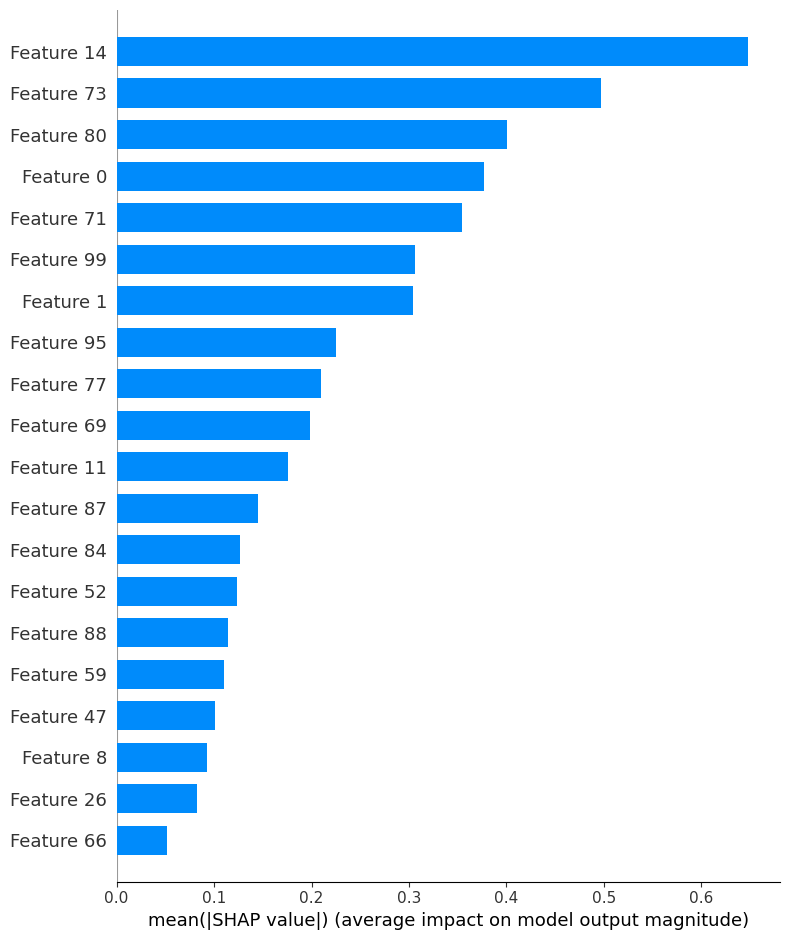

Run ID: 77ea3b774a164f3bb90fa5da56bc25f0


<Figure size 640x480 with 0 Axes>

In [394]:
# Fonction pour afficher l'importance des features et l'enregistrer comme artefact
def plot_feature_importance_with_mlflow(model, X, run_id):
    # Vérifiez que le modèle est bien entraîné, ici en prenant directement 'grid_search_lgb'
    best_model = model.best_estimator_.named_steps['classifier']  # Le modèle LightGBM

    # Calcul des valeurs SHAP
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)

    # Résumé de l'importance des features (affichage avec les noms de features)
    shap.summary_plot(shap_values, X, plot_type="bar")

    # Sauvegarder le plot SHAP comme image
    shap_summary_file = "shap_summary_plot.png"
    plt.savefig(shap_summary_file)
    
    # Loguer l'artefact dans MLflow
    mlflow.log_artifact(shap_summary_file)

# Démarrer un run MLflow
with mlflow.start_run() as run:
    # Si vous avez utilisé un GridSearchCV, utilisez 'grid_search_lgb' pour obtenir le meilleur modèle
    best_model = grid_search_lgb.best_estimator_.named_steps['classifier']
    
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(best_model, "model")
    
    # Log des métriques (par exemple, accuracy)
    accuracy = accuracy_score(y_val, grid_search_lgb.predict(X_val))
    mlflow.log_metric("accuracy", accuracy)
    
    # Log des artefacts (SHAP plot)
    plot_feature_importance_with_mlflow(grid_search_lgb, X_train, run.info.run_id)
    
    # Log d'autres artefacts si nécessaire
    mlflow.log_artifact("other_file.txt")

    print(f"Run ID: {run.info.run_id}")

2024/10/18 14:57:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


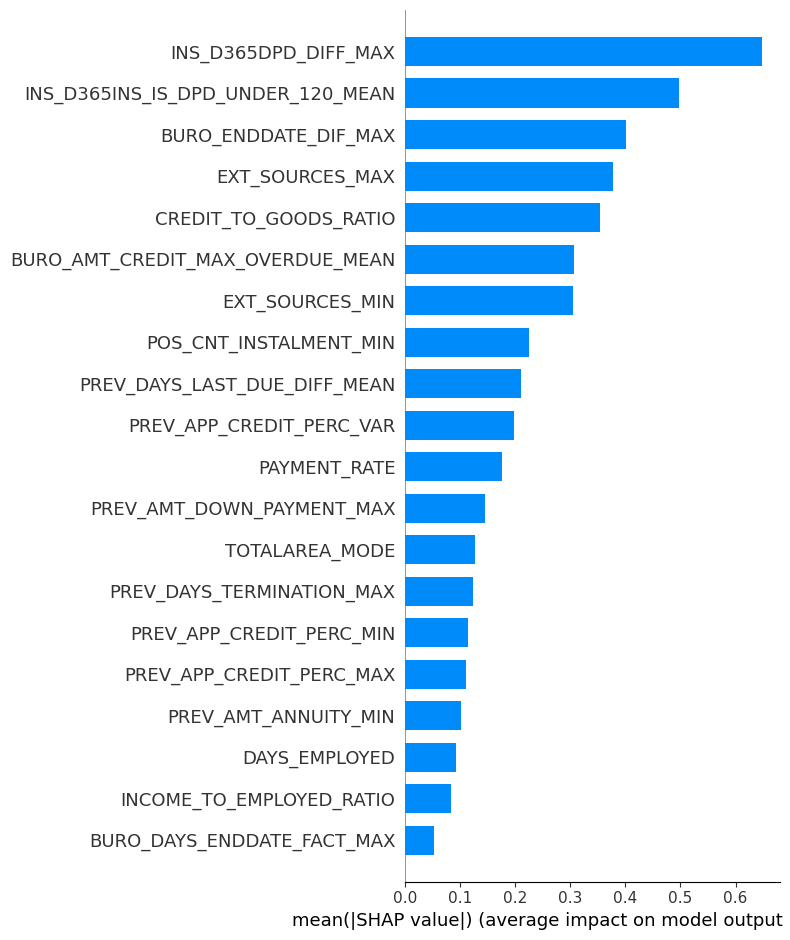

Run ID: 816b636b8cc6406f9086379d68c8820b


<Figure size 640x480 with 0 Axes>

In [396]:
# Fonction pour afficher l'importance des features et l'enregistrer comme artefact
def plot_feature_importance_with_mlflow(model, X, run_id):
    # Vérifiez que le modèle est bien entraîné, ici en prenant directement 'grid_search_lgb'
    best_model = model.best_estimator_.named_steps['classifier']  # Le modèle LightGBM

    # Calcul des valeurs SHAP
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)

    # Résumé de l'importance des features (affichage avec les noms de features)
    shap.summary_plot(shap_values, X, plot_type="bar")

    # Sauvegarder le plot SHAP comme image
    shap_summary_file = "shap_summary_plot.png"
    plt.savefig(shap_summary_file)
    
    # Loguer l'artefact dans MLflow
    mlflow.log_artifact(shap_summary_file)

# Démarrer un run MLflow
with mlflow.start_run() as run:
    # Si vous avez utilisé un GridSearchCV, utilisez 'grid_search_lgb' pour obtenir le meilleur modèle
    best_model = grid_search_lgb.best_estimator_.named_steps['classifier']
    
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(best_model, "model")
    
    # Log des métriques (par exemple, accuracy)
    accuracy = accuracy_score(y_val, grid_search_lgb.predict(X_val))
    mlflow.log_metric("accuracy", accuracy)
    
    # Créer un DataFrame avec les bonnes colonnes si ce n'est pas déjà fait
    X_train_df = pd.DataFrame(X_train, columns=data.columns[:-1])  # Assurez-vous que les noms sont corrects
    
    # Log des artefacts (SHAP plot)
    plot_feature_importance_with_mlflow(grid_search_lgb, X_train_df, run.info.run_id)
    
    # Log d'autres artefacts si nécessaire
    mlflow.log_artifact("other_file.txt")

    print(f"Run ID: {run.info.run_id}")

C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


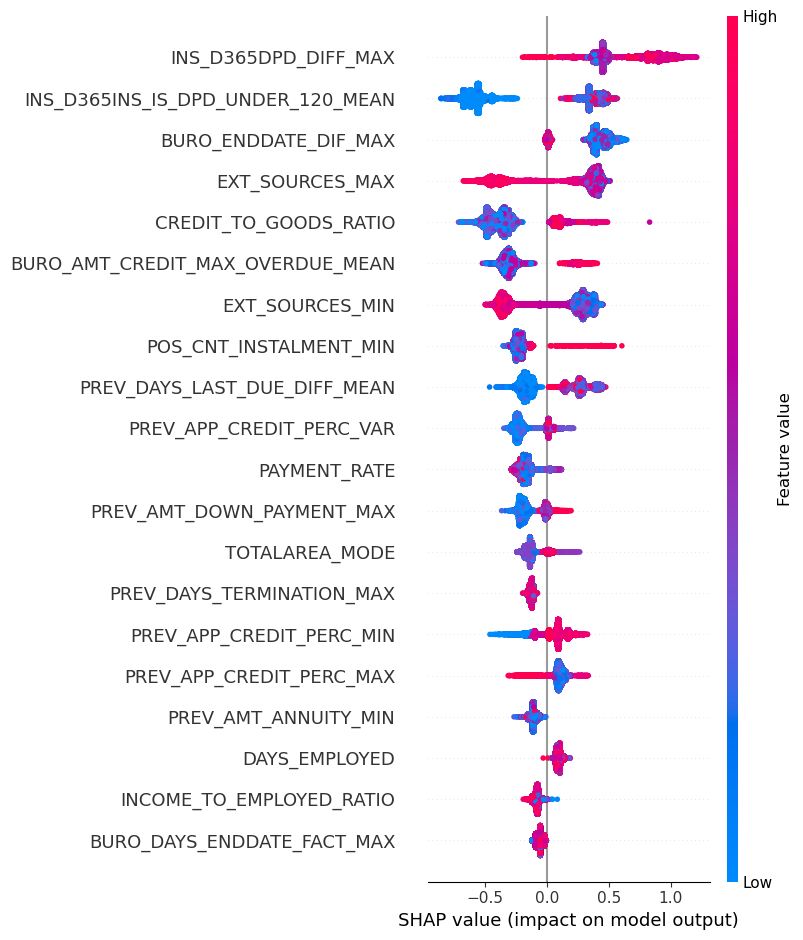

In [398]:
# Assurez-vous que X_val est un DataFrame avec des noms de colonnes
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Créer un explainer basé sur LightGBM (ou votre modèle final)
explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])

# Calculer les valeurs SHAP pour les données de validation
shap_values = explainer.shap_values(X_val_df)

# Graphique d'importance des features global
shap.summary_plot(shap_values, X_val_df, feature_names=X.columns)

In [399]:
# Utilisez TreeExplainer de SHAP pour le modèle LightGBM
explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])

# Calculer les valeurs SHAP pour le jeu de validation
shap_values = explainer.shap_values(X_val_df)

client_idx = 10  # Par exemple, le 10ème client

# Vérifiez si shap_values est une liste (pour la classification binaire)
if isinstance(shap_values, list):
    # Utilisez shap_values pour la deuxième classe (classe 1 si binaire)
    class_idx = 1

    # Visualisation de l'importance locale pour le client donné avec SHAP
    shap.force_plot(
        explainer.expected_value[class_idx],  # Utilisez expected_value pour la classe 1
        shap_values[class_idx][client_idx, :],  # shap_values pour la classe 1
        X_val_df.iloc[client_idx, :]  # Données du client
    )
else:
    # Visualisation de l'importance locale pour le client donné (classification mono-classe)
    shap.force_plot(
        explainer.expected_value,  # expected_value si une seule classe
        shap_values[client_idx, :],  # shap_values pour le client donné
        X_val_df.iloc[client_idx, :]  # Données du client
    )

C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [402]:
import shap
shap.initjs()

In [404]:
# Visualisation de l'importance locale pour le client donné
shap.force_plot(
    explainer.expected_value,  # Pas d'indexation par classe pour expected_value
    shap_values[client_idx, :],  # Pas d'indexation par classe pour shap_values
    X_val_df.iloc[client_idx, :]  # Données du client
)

In [406]:
# Fonction pour expliquer et sauvegarder l'importance locale avec SHAP
def explain_with_shap_and_log(explainer, shap_values, X_val_df, client_idx, run_id):
    # Vérifiez si shap_values est une liste (pour la classification binaire)
    if isinstance(shap_values, list):
        class_idx = 1  # Pour la deuxième classe (par exemple, "Prospect")

        # Visualisation de l'importance locale pour le client donné
        shap_fig = shap.force_plot(
            explainer.expected_value[class_idx],  # Utilisez expected_value pour la classe 1
            shap_values[class_idx][client_idx, :],  # shap_values pour la classe 1
            X_val_df.iloc[client_idx, :]  # Données du client
        )
    else:
        # Si shap_values n'est pas une liste, c'est probablement une tâche de régression ou une classification mono-classe
        shap_fig = shap.force_plot(
            explainer.expected_value,  # Utilisation directe si une seule classe
            shap_values[client_idx, :],  # Pas d'indexation par classe
            X_val_df.iloc[client_idx, :]  # Données du client
        )

    # Sauvegarde de la visualisation SHAP en tant que fichier image
    shap_image_file = "shap_force_plot.png"
    shap.save_html(shap_image_file, shap_fig)  # Enregistre l'explication sous forme de fichier HTML

    # Loguer l'explication SHAP dans MLflow
    mlflow.log_artifact(shap_image_file)
    print(f"SHAP explanation saved as artifact: {shap_image_file}")

# Démarrer un run MLflow
with mlflow.start_run() as run:
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Log des métriques (par exemple, accuracy)
    accuracy = accuracy_score(y_val, grid_search_lgb.predict(X_val))
    mlflow.log_metric("accuracy", accuracy)
    
    # Créer un DataFrame avec les bonnes colonnes si ce n'est pas déjà fait
    X_train_df = pd.DataFrame(X_train, columns=data.columns[:-1])  # Assurez-vous que les noms sont corrects
    X_val_df = pd.DataFrame(X_val, columns=data.columns[:-1])  # Pareil pour X_val
    
    # Initialisation de SHAP avec l'explainer
    explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])
    shap_values = explainer.shap_values(X_val_df)
    
    # Expliquer une instance (par exemple, le 10ème client) et enregistrer la visualisation
    explain_with_shap_and_log(explainer, shap_values, X_val_df, client_idx=10, run_id=run.info.run_id)
    
    # Log d'autres artefacts si nécessaire
    mlflow.log_artifact("other_file.txt")

    print(f"Run ID: {run.info.run_id}")

2024/10/18 14:58:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SHAP explanation saved as artifact: shap_force_plot.png
Run ID: d78031bfc2274da9a7d50d7821b71485


C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [407]:
import mlflow
import mlflow.lightgbm

# Enregistrez le modèle dans MLflow
with mlflow.start_run():
    # Log de l'entraînement du modèle
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Log des paramètres du modèle (optionnel)
    mlflow.log_param("max_depth", grid_search_lgb.best_params_['classifier__max_depth'])

    # Log des métriques (optionnel)
    mlflow.log_metric("accuracy", accuracy_score(y_val, grid_search_lgb.predict(X_val)))

2024/10/18 14:58:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/10/18 14:58:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


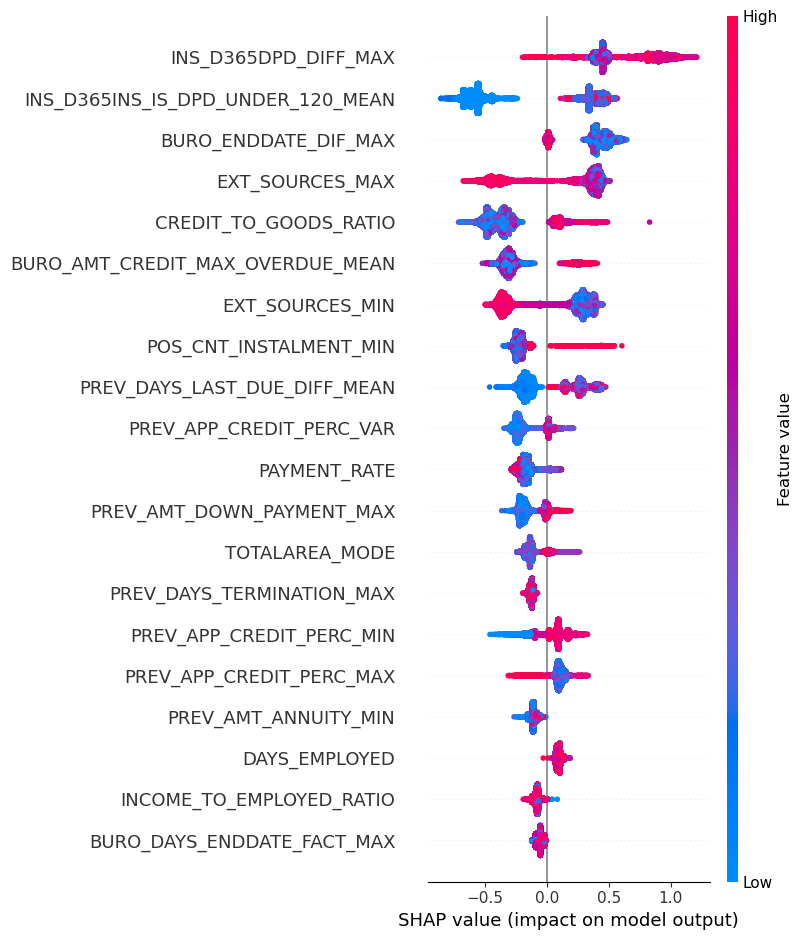

In [408]:
# Créer un fichier texte avant de l'enregistrer
with open("other_file.txt", "w") as f:
    f.write("Ceci est un fichier texte exemple pour l'enregistrement dans MLflow.")

# Log du fichier texte dans MLflow
with mlflow.start_run():
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Créer une visualisation SHAP
    shap.initjs()  # Initialiser les éléments JS pour SHAP
    shap.summary_plot(shap_values, X_val_df, feature_names=X_val_df.columns, show=False)  # Visualisation SHAP
    
    # Enregistrer la visualisation SHAP
    plt.savefig("shap_summary_plot.png")
    
    # Log de la visualisation SHAP dans MLflow
    mlflow.log_artifact("shap_summary_plot.png")
    
    # Log du fichier texte
    mlflow.log_artifact("other_file.txt")


In [409]:
from lime.lime_tabular import LimeTabularExplainer

# Assurez-vous que X_train est un DataFrame avec des noms de colonnes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Initialisation de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train_df.values, 
    feature_names=X_train_df.columns, 
    class_names=['Non Prospect', 'Prospect'], 
    discretize_continuous=True
)

# Sélection d'une instance à expliquer
client_idx = 10  # Par exemple, le 10ème client
exp = explainer.explain_instance(
    X_val_df.iloc[client_idx].values, 
    grid_search_lgb.predict_proba, 
    num_features=10
)

# Visualisation de l'explication locale
exp.show_in_notebook(show_all=False)

In [410]:
# Fonction pour expliquer une instance avec LIME et sauvegarder l'explication comme artefact
def explain_with_lime_and_log(model, X_train, X_val, client_idx, run_id):
    # Initialisation de LIME
    explainer = LimeTabularExplainer(
        X_train.values, 
        feature_names=X_train.columns, 
        class_names=['Non Prospect', 'Prospect'], 
        discretize_continuous=True
    )

    # Sélection d'une instance à expliquer
    exp = explainer.explain_instance(
        X_val.iloc[client_idx].values, 
        model.predict_proba, 
        num_features=10
    )

    # Visualisation de l'explication locale
    exp_image_file = "lime_explanation.png"
    exp.save_to_file(exp_image_file)
    
    # Loguer l'explication LIME dans MLflow
    mlflow.log_artifact(exp_image_file)
    print(f"LIME explanation saved as artifact: {exp_image_file}")

# Démarrer un run MLflow
with mlflow.start_run() as run:
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Log des métriques (par exemple, accuracy)
    accuracy = accuracy_score(y_val, grid_search_lgb.predict(X_val))
    mlflow.log_metric("accuracy", accuracy)
    
    # Créer un DataFrame avec les bonnes colonnes si ce n'est pas déjà fait
    X_train_df = pd.DataFrame(X_train, columns=data.columns[:-1])  # Assurez-vous que les noms sont corrects
    X_val_df = pd.DataFrame(X_val, columns=data.columns[:-1])  # Pareil pour X_val
    
    # Expliquer une instance (par exemple, le 10ème client) et enregistrer la visualisation
    explain_with_lime_and_log(grid_search_lgb, X_train_df, X_val_df, client_idx=10, run_id=run.info.run_id)
    
    # Log d'autres artefacts si nécessaire
    mlflow.log_artifact("other_file.txt")

    print(f"Run ID: {run.info.run_id}")

2024/10/18 15:00:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LIME explanation saved as artifact: lime_explanation.png
Run ID: e8c07e0d969843ddbfc3bac71f28299f


In [411]:
# !pip install lime

In [412]:
# Assurez-vous que X_train est un DataFrame avec des noms de colonnes   # à vérifier puis supprimer
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Initialisation de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train_df.values, 
    feature_names=X_train_df.columns, 
    class_names=['Non Prospect', 'Prospect'], 
    discretize_continuous=True
)

# Sélection d'une instance à expliquer
client_idx = 10  # Par exemple, le 10ème client
exp = explainer.explain_instance(
    X_val_df.iloc[client_idx].values, 
    grid_search_lgb.predict_proba, 
    num_features=10
)

# Sauvegarder l'explication LIME en tant que fichier HTML
lime_html_path = "lime_explanation.html"
exp.save_to_file(lime_html_path)

# Enregistrer le modèle et l'explication dans MLflow
with mlflow.start_run():
    # Enregistrer le modèle dans MLflow
    mlflow.sklearn.log_model(grid_search_lgb.best_estimator_, "model")
    
    # Enregistrer l'explication LIME en tant qu'artefact
    mlflow.log_artifact(lime_html_path)
    
    # Vous pouvez aussi loguer d'autres informations (par exemple, des métriques ou des fichiers)
    mlflow.log_param("Client Index", client_idx)
    mlflow.log_param("Features Explained", 10)  # Exemple de paramètre

2024/10/18 15:00:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/10/18 15:00:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


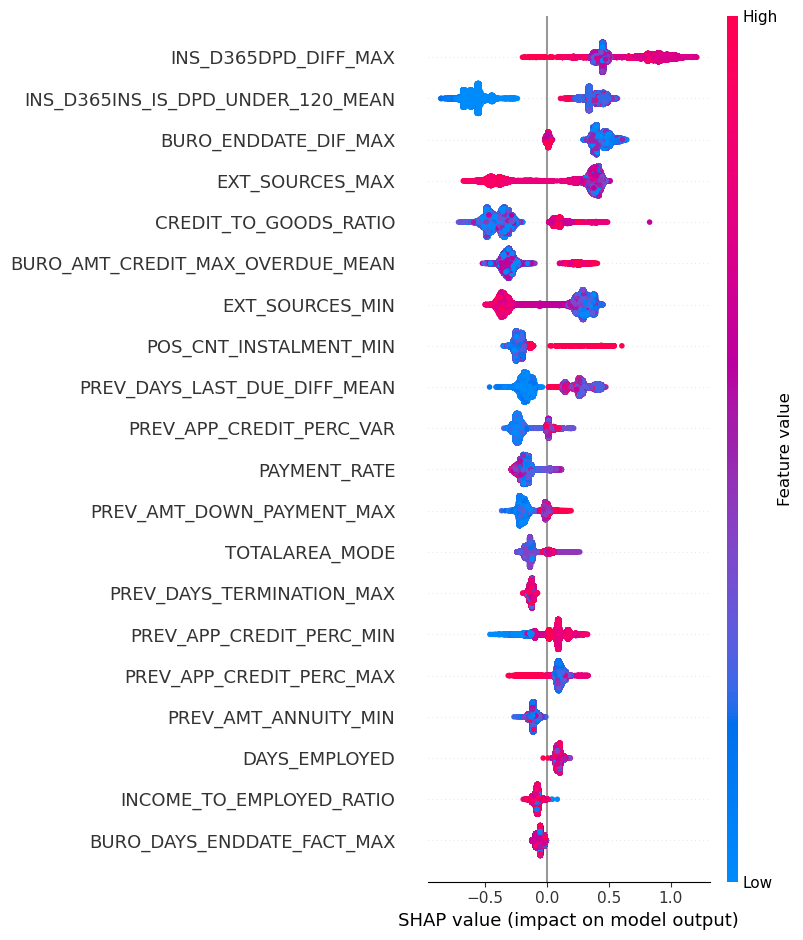

In [414]:
# Créer les DataFrames pour X_train et X_val en utilisant les colonnes de 'data'  # à supprimer 
X_train_df = pd.DataFrame(X_train, columns=data.columns[:-1])  # Toutes les colonnes sauf la dernière
X_val_df = pd.DataFrame(X_val, columns=data.columns[:-1])  # Pareil pour X_val

# Démarrer un run MLflow
with mlflow.start_run():
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")
    
    # Log des métriques (exemple)
    mlflow.log_metric("accuracy", accuracy_score(y_val, grid_search_lgb.predict(X_val)))

    # Log des artefacts (par exemple, un fichier SHAP)
    shap.summary_plot(shap_values, X_val_df, feature_names=X_val_df.columns, show=False)
    plt.savefig("shap_summary_plot.png")
    mlflow.log_artifact("shap_summary_plot.png")
    
    # Log d'autres fichiers si nécessaire
    mlflow.log_artifact("other_file.txt")

In [422]:
# Sauvegarde des modèles shapely pour le dashboard

# Utilisez TreeExplainer de SHAP pour le modèle LightGBM
explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])

# Calculer les valeurs SHAP pour le jeu de validation
shap_values = explainer.shap_values(X_val_df)

# Sauvegarder l'explainer et les valeurs SHAP avec joblib
joblib.dump(explainer, 'shap_explainer.pkl')
joblib.dump(shap_values, 'shap_values.pkl')

C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


['shap_values.pkl']

In [423]:
# Chargement des valeurs SHAP

# Charger l'explainer et les valeurs SHAP depuis les fichiers
loaded_explainer = joblib.load('shap_explainer.pkl')
loaded_shap_values = joblib.load('shap_values.pkl')

# Utiliser l'explainer chargé pour générer des visualisations
client_idx = 10  # Par exemple, le 10ème client

# Vérifier si shap_values est une liste (pour la classification binaire)
if isinstance(loaded_shap_values, list):
    class_idx = 1  # Utilisez la classe 1 si classification binaire
    shap.force_plot(
        loaded_explainer.expected_value[class_idx],
        loaded_shap_values[class_idx][client_idx, :],
        X_val_df.iloc[client_idx, :]
    )
else:
    shap.force_plot(
        loaded_explainer.expected_value,
        loaded_shap_values[client_idx, :],
        X_val_df.iloc[client_idx, :]
    )


In [424]:
# Sauvegarder les prédictions et les vraies étiquettes dans un fichier CSV
predictions = grid_search_lgb.predict(X_val)
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Label': predictions
})
results_df.to_csv('predictions_vs_true_labels.csv', index=False)


In [425]:
# Sauvegarder l'importance des features basée sur SHAP dans un fichier CSV
shap_importance = pd.DataFrame({
    'Feature': X_val_df.columns,
    'Importance': np.mean(np.abs(shap_values[1]), axis=0)  # Moyenne des valeurs absolues des SHAP
})
shap_importance.to_csv('shap_feature_importance.csv', index=False)


In [439]:
print(mlflow.get_tracking_uri())

file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/mlruns


In [ ]:
mlflow ui --backend-store-uri file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/mlruns

In [92]:
mlflow.set_tracking_uri("file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/mlruns")

In [ ]:
rm -rf mlruns/.trash

In [92]:
with mlflow.start_run(): 
    mlflow.log_metric("accuracy", accuracy_score(y_val, grid_search_lgb.predict(X_val)))
    mlflow.log_param("param_name", param_value)
    mlflow.log_artifact("shap_summary_plot.png")

NameError: name 'param_value' is not defined

In [11]:
from mlflow.models.signature import infer_signature

In [3]:
import mlflow.sklearn

In [15]:
import mlflow

In [17]:
print(MLFLOW_TRACKING_URI)

NameError: name 'MLFLOW_TRACKING_URI' is not defined

In [7]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type
0,ecaabee5f07a4bd193fd889723f164fa,0,RUNNING,file:///C:/Users/SOUKA/anaconda3/envs/projet7_...,2024-10-28 13:20:48.395000+00:00,NaT,selective-whale-532,C:\Users\SOUKA\anaconda3\Lib\site-packages\ipy...,SOUKA,LOCAL
1,a7f41917f0d94a538c8f536052a023e7,0,RUNNING,file:///C:/Users/SOUKA/anaconda3/envs/projet7_...,2024-10-28 13:20:27.013000+00:00,NaT,honorable-sow-703,C:\Users\SOUKA\anaconda3\Lib\site-packages\ipy...,SOUKA,LOCAL
2,27983064ebb74ae79897875c3ba268ca,0,FAILED,file:///C:/Users/SOUKA/anaconda3/envs/projet7_...,2024-10-13 14:07:10.098000+00:00,2024-10-13 14:07:10.144000+00:00,clumsy-yak-871,C:\Users\SOUKA\anaconda3\Lib\site-packages\ipy...,SOUKA,LOCAL


In [19]:
mlflow.get_artifact_uri()

'file:///C:/Users/SOUKA/anaconda3/envs/projet7_IMS/mlruns/0/7f15cf80209847d592bcbb039de24677/artifacts'